**Project 1: Analyzing IMDB Movie Reviews for Their Sentiment, Making a Model**

The goal for this project is to take IMDB reviews, and perform a sentiment analysis of them. Then if possible, use the reviews to predict possible ratings given by the user who wrote the review. The data being used originally came from a user on the Kaggle website, which I usuing after trimming out unneccessary columns of data like time of the review, and generes to make the data less cumbersome for only looking at each movie's text review. As the project progresses, I can untrim movie ratings to try and utilize them with the project for validating predictions of movie ratings, if possible.
 
So far the main input being used is going to be each review in the review column in the .csv which has been trimmed up a little in the code.
 
With the goal of getting a sentiment analysis out of this, I am attempting to get the simplified text data to vectorize for further proccessing of the text. The exact output I plan to get will be two columns with each review's sentiment score as an integer and the second will say if it is positive or negative with a string or boolean. Which I may be able to use to further train a model for predicting possible ratings left by those reviewers.

**The Dataset**

IMBD Movie Rating (2022)
Original URL: https://www.kaggle.com/datasets/youssefamdouni/imbd-movie-rating

The dataset includes columns for: Title, Rating, Gender/Genre, Movie ID, and the review

35,485 entries by default, Trimmed .csv used has 20,000


**Training a Model to Calculate Sentiment**

Will be attempting to use tokenize and refine those tokens for a goal of better efficiency, and then perform sentiment analysis on the data using the tools TextBlob and Vader tools. Currently am investigating the different sentiment values each provides, and seeing why they might be different.
My data does not have sentiment values to start from, so I will either dig deeper into the differences in the sentimence tools to make an informed decision, or push forwards into making a validation set, and continuing with making a trained model.


In [114]:
# import all of the python modules/packages you'll need here
import pandas as pd
import re
import nltk
from textblob import TextBlob
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
#from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer

#from argparse import Namespace
#from collections import Counter
#from nltk.corpus import stopwords
import json
import os
import re
import string

import numpy as np
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
#nltk.download('stopwords')
#stop=set(stopwords.words('english'))
# ...



Here is where I got started and was looking at the data I am working with. A couple graphs were used and tuned to get a goot cut off for the data compared to the full dataset.

In [115]:
df = pd.read_csv('/kaggle/input/imdb-ratings-3/IMDB_ratings3.csv')

print(df.head())
print (df.info())

#Make text_length hold the word count for each review
df['text_length'] = df['Review'].apply(len)
print(df['text_length'].describe())
print(df['Review'].head())
'''
# Create a bar graph of review lengths
plt.figure(figsize=(10, 6))
sorted_df = df.sort_values(by='text_length', ascending=False)
plt.bar(range(len(sorted_df)), sorted_df['text_length'], align='center')
plt.xlabel('Review Index')
plt.ylabel('Review Word Length')
plt.title('Review Word Length Distribution')
plt.show()
print('This graph shows that just of 10,000 reviews(half) are between 1,000 and 9,000 words long')

#Data Exploration ideas from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

df['Review'].str.len().hist()

print('This shows that 20% of the data contain reviews with between 1,000 and 14,000 characters in them')
'''
# Define a function to calculate text length
def calculate_text_length(text):
    words = re.findall(r'\w+', text)
    return len(words)


   Entry     Title  Global_Rating                    Gender   ID_Movie  \
0      0  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
1      1  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
2      2  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
3      3  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
4      4  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   

                                              Review  
0  This is a movie that plays on something everyo...  
1  The hype for The Menu intrigued me. The review...  
2  This film was something else, I am genuinely s...  
3  Nice try, but the satire doesn't land in this ...  
4  "The Menu" offers a trailer spectacular enough...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entry          20000 non

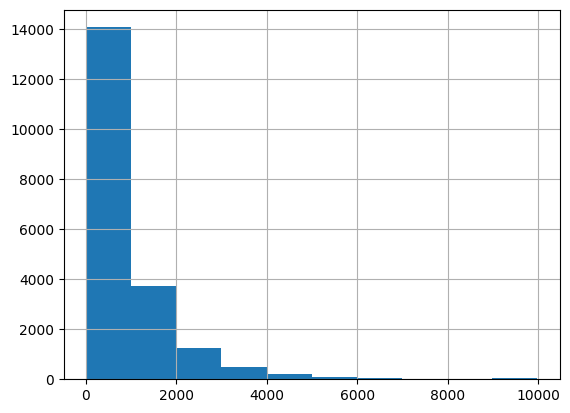The Vocabulary

Here is where the tokenization and use of TextBlob and Vader is. The tokens are then sorted and tags are assigned respective to their sentiment scores. TextBlob having a threshold of 0, and Vader with +/-.05

In [116]:
print(df.shape)

df['Review'][:5].str.split()

df['tokens']=df['Review'].str.lower().str.split()

#P.2
#stops = set(stopwords.words('english'))
#chars2remove = set(['.','!','/', '?'])
#
#lemmatizer = WordNetLemmatizer()
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])

threshold = 0
df['sentiment'] = df['Review'].apply(lambda review: TextBlob(review).sentiment.polarity)
df['tag'] = df['sentiment'].apply(lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral')
df.sentiment.value_counts(normalize=True)
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['Review'].apply(lambda review: analyzer.polarity_scores(review))
#df['vader_tag'] = df['vader_sentiment'].apply(lambda x: 'positive' if x > threshold else 'negative' if x < -threshold else 'neutral')
def analyze_sentiment(text, threshold_pos=0.05, threshold_neg=-0.05):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score > threshold_pos:
        return 'positive'
    elif compound_score < threshold_neg:
        return 'negative'
    else:
        return 'neutral'
    
df['vader_tag'] = df['Review'].apply(analyze_sentiment)

df_pos = df[df['tag']=='positive']
df_neg = df[df['tag']=='negative']
df_neu = df[df['tag']=='neutral']

(20000, 7)


Vocab started and sorted tokens with sentimence

In [117]:
vocab = dict()
for tweet_tokens in df['tokens']:
    for token in tweet_tokens:
        if token not in vocab:
            vocab[token] = 1
        else:
            vocab[token] += 1

len(vocab)

vocab_sorted = dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))
    

In [118]:
def create_vocab_list(tokens_column):
    vocab = dict()
    for rev_tokens in tokens_column:
        for token in rev_tokens:
            if token not in vocab:
                vocab[token]=1
            else:
                vocab[token]+=1
    
    vocab_sorted = dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))
    return vocab


vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1],reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1],reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1],reverse=True))


#vocab_sorted = dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))
#list(vocab_sorted.items())[:25]


In [119]:
list(vocab_pos.items())[:25]
list(vocab_neg.items())[:25]
list(vocab_neu.items())[:25]

[('the', 175),
 ('a', 127),
 ('to', 112),
 ('this', 110),
 ('and', 92),
 ('of', 89),
 ('i', 87),
 ('it', 76),
 ('is', 73),
 ('watch', 62),
 ('movie', 59),
 ('in', 53),
 ("don't", 50),
 ('film', 44),
 ('for', 44),
 ('was', 40),
 ('you', 39),
 ('but', 33),
 ('be', 30),
 ('with', 28),
 ('have', 26),
 ('my', 26),
 ('not', 26),
 ('like', 26),
 ('that', 23)]

In [120]:
top_n_to_remove = 200

for i, item in enumerate(vocab_sorted.items()):
    if i == top_n_to_remove:
        break
    if item[0] in vocab_pos:
        del vocab_pos[item[0]]
    if item[0] in vocab_neg:
        del vocab_neg[item[0]]
    if item[0] in vocab_neu:
        del vocab_neu[item[0]]

list(vocab_pos.items())[:20]

[('kind', 1505),
 ('big', 1490),
 ('especially', 1460),
 ('look', 1453),
 ('might', 1429),
 ('always', 1428),
 ('seems', 1412),
 ('different', 1403),
 ('thing', 1371),
 ('worth', 1360),
 ('old', 1358),
 ('got', 1355),
 ('it,', 1345),
 ('point', 1343),
 ('done', 1335),
 ('world', 1335),
 ('definitely', 1324),
 ('whole', 1309),
 ('come', 1307),
 ('far', 1300)]

In [121]:
list(vocab_neg.items())[:20]

[('worst', 511),
 ('boring', 420),
 ('ever', 409),
 ('waste', 405),
 ('terrible', 378),
 ('got', 368),
 ('thing', 352),
 ('minutes', 321),
 ('trying', 321),
 ("i've", 317),
 ('stupid', 313),
 ('gets', 310),
 ('hard', 310),
 ('down', 298),
 ('whole', 296),
 ('poor', 294),
 ('anything', 293),
 ('slow', 280),
 ('time.', 279),
 ('seems', 278)]

In [122]:
list(vocab_neu.items())[:20]

[('must', 10),
 ('.', 10),
 ('watched', 8),
 ('mmm', 8),
 ('4', 8),
 ('01100101', 7),
 ('00100000', 7),
 ('mmmm', 6),
 ('mm', 6),
 ('definitely', 6),
 ('10', 6),
 ('7', 6),
 ('que', 6),
 ('garbage.', 5),
 ('around', 5),
 ('watch.', 5),
 ('rather', 5),
 ('wish', 5),
 ('ever', 5),
 ('god', 5)]

In [123]:
print(df.head())
print(df['sentiment'])
print(df['tag'])

   Entry     Title  Global_Rating                    Gender   ID_Movie  \
0      0  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
1      1  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
2      2  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
3      3  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
4      4  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   

                                              Review  text_length  \
0  This is a movie that plays on something everyo...         3258   
1  The hype for The Menu intrigued me. The review...          985   
2  This film was something else, I am genuinely s...         1682   
3  Nice try, but the satire doesn't land in this ...          692   
4  "The Menu" offers a trailer spectacular enough...          971   

                                              tokens  sentiment       tag  \
0  [this, is, a, movie, that, plays, on, somethin...   0.048375

In [124]:
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}

print(f"positive tokens: {len(classifier_tokens['positive'])} \n negative tokens: {len(classifier_tokens['negative'])} \n neutral tokens: {len(classifier_tokens['neutral'])}")
#

positive tokens: 148035 
 negative tokens: 46592 
 neutral tokens: 1595


In [125]:
for sentiment in classifier_tokens:
    print(f"top 10 tokens for {sentiment} tweets: \n {classifier_tokens[sentiment][:20]}")

top 10 tokens for positive tweets: 
 ['kind', 'big', 'especially', 'look', 'might', 'always', 'seems', 'different', 'thing', 'worth', 'old', 'got', 'it,', 'point', 'done', 'world', 'definitely', 'whole', 'come', 'far']
top 10 tokens for negative tweets: 
 ['worst', 'boring', 'ever', 'waste', 'terrible', 'got', 'thing', 'minutes', 'trying', "i've", 'stupid', 'gets', 'hard', 'down', 'whole', 'poor', 'anything', 'slow', 'time.', 'seems']
top 10 tokens for neutral tweets: 
 ['must', '.', 'watched', 'mmm', '4', '01100101', '00100000', 'mmmm', 'mm', 'definitely', '10', '7', 'que', 'garbage.', 'around', 'watch.', 'rather', 'wish', 'ever', 'god']


In [126]:
review2classify_i = 5557
review2classify = df.iloc[review2classify_i,:]['tokens']
df.iloc[review2classify_i,:]

Entry                                                           5798
Title                                                      Trautmann
Global_Rating                                                    7.2
Gender                                     Biography  Drama  Romance
ID_Movie                                                   tt4642192
Review             David Kross was very believable as Bert Trautm...
text_length                                                      624
tokens             [david, kross, was, very, believable, as, bert...
sentiment                                                   0.089583
tag                                                         positive
vader_sentiment    {'neg': 0.083, 'neu': 0.822, 'pos': 0.095, 'co...
vader_tag                                                   positive
Name: 5557, dtype: object

In [127]:
pos = 0
neg = 0
neu = 0
for tok in review2classify:
    if tok in classifier_tokens['positive']:
        pos += 1
    elif tok in classifier_tokens['negative']:
        neg += 1
    elif tok in classifier_tokens['neutral']:
        neu += 1

print(f"pos: {pos}   neg: {neg}   neu: {neu}")


pos: 42   neg: 0   neu: 0


In [128]:
def predict_review_sentiment(review_tokens):
    pos = 0
    neg = 0
    neu = 0
    for tok in review_tokens:
        if tok in classifier_tokens['positive']:
            pos += 1
        elif tok in classifier_tokens['negative']:
            neg += 1
        elif tok in classifier_tokens['neutral']:
            neu += 1
    if pos > neg and pos > neu:
        return "positive"
    elif neu > pos and neu > neg:
        return "neutral"
    else:
        return "negative"

In [129]:
df['predicted_sentiment'] = df['tokens'].head(20).apply(lambda x: predict_review_sentiment(x))
#Possible this is not needed w/ textblob score

In [130]:
df.head(10)

,Entry,Title,Global_Rating,Gender,ID_Movie,Review,text_length,tokens,sentiment,tag,vader_sentiment,vader_tag,predicted_sentiment
0,0,The Menu,7.2,Comedy Horror Thriller,tt9764362,This is a movie that plays on something everyo...,3258,"[this, is, a, movie, that, plays, on, somethin...",0.048375,positive,"{'neg': 0.084, 'neu': 0.815, 'pos': 0.102, 'co...",positive,positive
1,1,The Menu,7.2,Comedy Horror Thriller,tt9764362,The hype for The Menu intrigued me. The review...,985,"[the, hype, for, the, menu, intrigued, me., th...",0.102304,positive,"{'neg': 0.043, 'neu': 0.821, 'pos': 0.136, 'co...",positive,positive
2,2,The Menu,7.2,Comedy Horror Thriller,tt9764362,"This film was something else, I am genuinely s...",1682,"[this, film, was, something, else,, i, am, gen...",0.264127,positive,"{'neg': 0.05, 'neu': 0.78, 'pos': 0.17, 'compo...",positive,positive
3,3,The Menu,7.2,Comedy Horror Thriller,tt9764362,"Nice try, but the satire doesn't land in this ...",692,"[nice, try,, but, the, satire, doesn't, land, ...",0.066667,positive,"{'neg': 0.079, 'neu': 0.76, 'pos': 0.161, 'com...",positive,positive
4,4,The Menu,7.2,Comedy Horror Thriller,tt9764362,"""The Menu"" offers a trailer spectacular enough...",971,"[""the, menu"", offers, a, trailer, spectacular,...",0.131667,positive,"{'neg': 0.091, 'neu': 0.809, 'pos': 0.099, 'co...",positive,positive
5,5,The Menu,7.2,Comedy Horror Thriller,tt9764362,"And that's all Folks, that's all you need to K...",1718,"[and, that's, all, folks,, that's, all, you, n...",0.280952,positive,"{'neg': 0.027, 'neu': 0.797, 'pos': 0.176, 'co...",positive,positive
6,6,The Menu,7.2,Comedy Horror Thriller,tt9764362,I waited months for this film thinking it woul...,957,"[i, waited, months, for, this, film, thinking,...",0.214217,positive,"{'neg': 0.035, 'neu': 0.812, 'pos': 0.153, 'co...",positive,positive
7,7,The Menu,7.2,Comedy Horror Thriller,tt9764362,This looked like an interesting film based on ...,721,"[this, looked, like, an, interesting, film, ba...",0.089205,positive,"{'neg': 0.091, 'neu': 0.805, 'pos': 0.104, 'co...",negative,positive
8,8,The Menu,7.2,Comedy Horror Thriller,tt9764362,"From the start and the trailer, I think many w...",5361,"[from, the, start, and, the, trailer,, i, thin...",0.115074,positive,"{'neg': 0.114, 'neu': 0.767, 'pos': 0.12, 'com...",positive,positive
9,9,The Menu,7.2,Comedy Horror Thriller,tt9764362,The Menu isn't the first to satirise the rich ...,860,"[the, menu, isn't, the, first, to, satirise, t...",0.363455,positive,"{'neg': 0.064, 'neu': 0.603, 'pos': 0.333, 'co...",positive,positive


In [131]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df['tag'], df['vader_tag'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

array([[ 3042,   102,   955],
       [   53,    66,    79],
       [ 2701,   181, 12821]])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

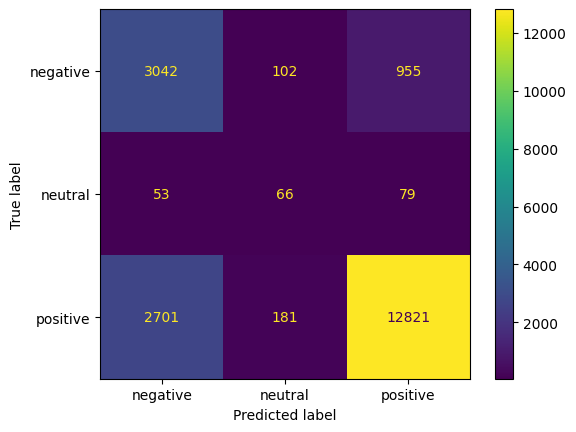

In [132]:
disp = ConfusionMatrixDisplay(confusion_matrix(df['tag'], df['vader_tag']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()

The accuracy of TextBlob's sentiment scores vs Vader's

In [133]:
mod_accuracy = accuracy_score(df['tag'], df['vader_tag'])
print(f"our ad hoc model's accuracy is: {mod_accuracy*100:.2f}%")

our ad hoc model's accuracy is: 79.64%


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Saved possible code for future part, but not in use

In [134]:
class Vocabulary(object):
    #Proccesses the text, and tracks vocabulary for mapping
    
    def _init_(self, token_to_idx=None, add_unk=True,unk_token="<UNK>"):
        #token_to_idx (dict): a pre-existing map of tokens to indices
        #add_unk (bool): a flag that indicates whether to add the UNK token
        #unk_token (str): the UNK token to add into the Vocabulary
        
        
        if token_to_idx == None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token ={idx:token for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serialize(self):
        #Returns a serializable dictionary
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}
    @classmethod
    def fro_serializable(cls,content):
        return cls(**contents)
    
    def add_token(self,token):
        #update mapping dictionary based on token provided
        
        if token in self._token_t_idx:
            index = self._token_to_idx[token]
        else:
            index=len(self._token_to_idx[token])
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    def add_many(self, tokens):
        #adds list of tokens to vocab
        #inputs tokens(list) and returns index(list)/indices of tokens
        return[self.add_token(token)for token in tokens]
    
    def lookup_token(self,token):
        #Get the indexx associated with a token, or UNK_index if token not present
        if self.unk_index >= 0:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self.token_to_idx[token]
        
    def lookup_index(self, index):
        #Takes index and returns the token associated with it
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return"<Vocabulary(size=%d)>" % len(self)
    
    def __len__(self):
        return len(self._token_to_idx)







class Vocabulary(objective):
    def _init_(self, token_to_idx=None, add_unk+True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

SyntaxError: invalid syntax (1360875602.py, line 69)

The Vectorizor

In [ ]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab , rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=20):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        
        review_vocab = Vocabulary(add_unk=True)
        #rating_vocab = Vocabulary(add_unk=False)
        stop_words = set(stopwords.words('english'))
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff and word not in stop_words:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)
"""
    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        #create serializable dictionary for caching
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

The Dataset

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is at the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

**Prep-work**

Here some of the text proccessing does function.

In [ ]:

def preprocess_text(text):
    #Set all text to lowercase
    text=text.lower()
    #Remove anything not a letter of the alphabet or a space, i.e, empty string replaces it
    text + re.sub(r'[^a-zA-Z\s]','', text)
    tokens = word_tokenize(text)
    #Remove stop words from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens
df['processed_text'] = df['Review'].apply(preprocess_text)

# Save the DataFrame with processed text back to a new CSV file
df.to_csv("preprocessed_sentiment_data.csv", index=False)
print(df['processed_text'].head())

# Get sentiment values from the tokenized reviews
#df['sentiment'] = df['processed_text'].apply(lambda review: TextBlob(review).sentiment)
df.sentiment.value_counts(normalize=True)
#df['processed_text'].dropna()
#df['sentiment'] = df['processed_text'].apply(lambda row: TextBlob(row['processed_text']).sentiment, axis=1)
#df['sentiment'] = df['processed_text'].sentiment

print(df['sentiment'].head())




args = Namespace(
    #Input data file(after pre-proccessing)
    input_data_path = '~/data/',
    review_csv = 'preprocessed_sentiment_data.csv',
    model_state_file = 'model.pth',
    #Output data and path info
    save_dir = '~/data/Project1/',
    vectorize_file = 'vectorizer.json',
    #Training parameters
    batch_size = 500,
    early_stopping_criteria = 3,
    learning_rate = 0.001,
    num_epochs = 6,
    seed = 42,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=False,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)
    

Initialization

In [ ]:
'''
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()
'''